In [18]:
import pandas as pd
import matplotlib.pyplot  as plt
import os



# Чтение CSV файла в DataFrame
df = pd.read_csv('seattle-weather.csv', error_bad_lines=False)


for column in df.columns:
    if df[column].dtype == object:  # Проверяем, является ли столбец строковым
        df[column] = pd.to_numeric(df[column], errors='coerce')  # Преобразуем в числовой формат
        mean_value = df[column].mean()  # Вычисляем среднее значение
        df[column].fillna(mean_value, inplace=True)  # Заменяем NaN на среднее значение

df = df.drop('date', axis = 1)
df = df.drop('weather', axis = 1)
validation = df[461:len(df)]



<ipython-input-18-3e7d9ff8bf73>:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('seattle-weather.csv', error_bad_lines=False)


In [19]:


validation



,precipitation,temp_max,temp_min,wind
461,12.7,12.2,7.2,5.0
462,39.1,8.3,5.0,3.9
463,0.8,13.3,6.1,3.1
464,0.0,12.2,6.1,2.4
465,9.4,15.0,8.9,6.4
...,...,...,...,...
1456,8.6,4.4,1.7,2.9
1457,1.5,5.0,1.7,1.3
1458,0.0,7.2,0.6,2.6
1459,0.0,5.6,-1.0,3.4


In [20]:


df



,precipitation,temp_max,temp_min,wind
0,0.0,12.8,5.0,4.7
1,10.9,10.6,2.8,4.5
2,0.8,11.7,7.2,2.3
3,20.3,12.2,5.6,4.7
4,1.3,8.9,2.8,6.1
...,...,...,...,...
1456,8.6,4.4,1.7,2.9
1457,1.5,5.0,1.7,1.3
1458,0.0,7.2,0.6,2.6
1459,0.0,5.6,-1.0,3.4


In [26]:
def data_split(ts, param="3", train_percentage=0.67):
    timeseries = ts[ts.columns[int(param)]].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries



In [27]:
import torch

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)



In [28]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x



In [29]:
train, test, total = data_split(df)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

<ipython-input-27-0a9dfe5d01f1>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


In [30]:


import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

EPOCHS = 200



In [31]:

def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        # Validation
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))



    return y_pred_train, y_pred_test, model

In [32]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 1.4773, test RMSE 1.4105
Epoch 1: train RMSE 1.4028, test RMSE 1.3380
Epoch 2: train RMSE 1.3511, test RMSE 1.2825
Epoch 3: train RMSE 1.3391, test RMSE 1.2698
Epoch 4: train RMSE 1.3313, test RMSE 1.2640
Epoch 5: train RMSE 1.3274, test RMSE 1.2624
Epoch 6: train RMSE 1.3306, test RMSE 1.2623
Epoch 7: train RMSE 1.3310, test RMSE 1.2627
Epoch 8: train RMSE 1.3395, test RMSE 1.2795
Epoch 9: train RMSE 1.3315, test RMSE 1.2697
Epoch 10: train RMSE 1.3240, test RMSE 1.2626
Epoch 11: train RMSE 1.3319, test RMSE 1.2675
Epoch 12: train RMSE 1.3280, test RMSE 1.2711
Epoch 13: train RMSE 1.3252, test RMSE 1.2670
Epoch 14: train RMSE 1.3289, test RMSE 1.2706
Epoch 15: train RMSE 1.3241, test RMSE 1.2626
Epoch 16: train RMSE 1.3384, test RMSE 1.2714
Epoch 17: train RMSE 1.3259, test RMSE 1.2631
Epoch 18: train RMSE 1.3265, test RMSE 1.2647
Epoch 19: train RMSE 1.3259, test RMSE 1.2648
Epoch 20: train RMSE 1.3253, test RMSE 1.2624
Epoch 21: train RMSE 1.3413, test RMSE 1.274

In [33]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [34]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
    # shift train predictions for plotting
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        # shift test predictions for plotting
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [50, 12]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()


In [35]:


def validate_on_auto_measurement(model):
    valid_train, valid_test, valid_total = data_split(validation)
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred

    print(f"Метрики для автоматического измерения:")
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)



Метрики для автоматического измерения:
MSE: 1.4165893
RMSE: 1.1902055537180618
MAE: 0.90529394
MAPE: 29.291662573814392
R2: -4.493038132794788


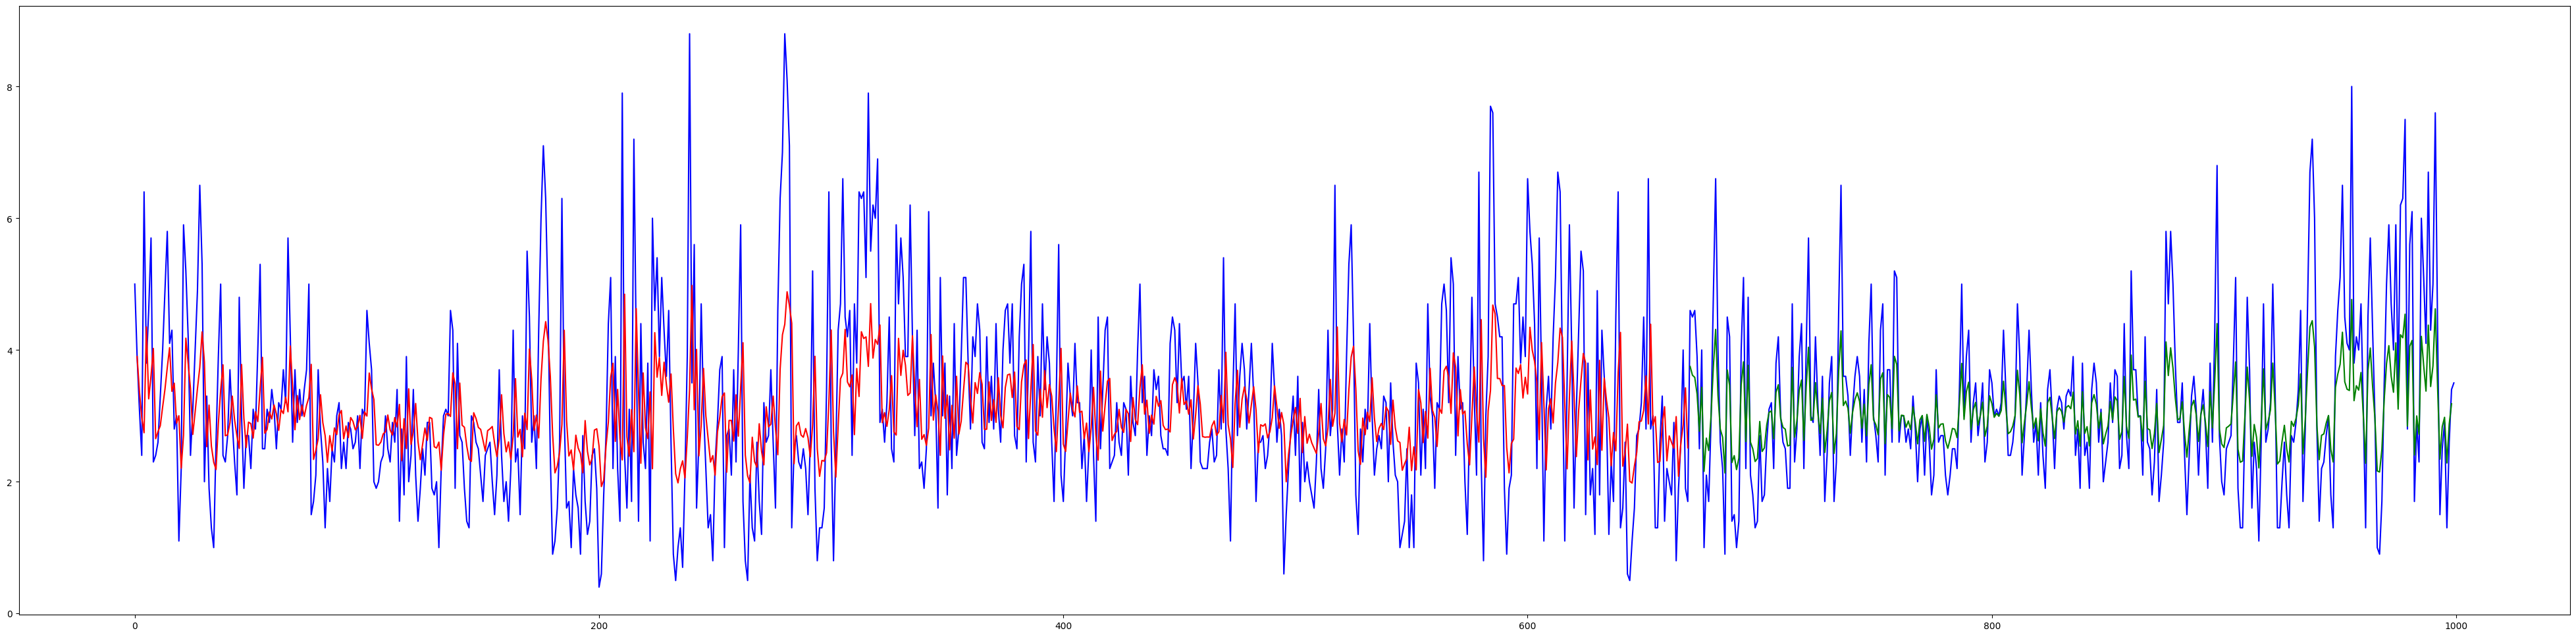

In [36]:
validate_on_auto_measurement(model)